In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv2DTranspose
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import pathlib
import os
import datetime
import time
import keras_cv

In [ ]:
# 데이터셋 다운로드 및 준비
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# 현재 데이터 경로 확인
print("데이터셋 경로:", data_dir)

# 폴더 구조 확인 (문제 파악용)
print("폴더 내 항목:", [item.name for item in data_dir.glob('*')])

# 실제 꽃 이미지가 있는 폴더로 경로 수정
if 'flower_photos' in [item.name for item in data_dir.glob('*')]:
    data_dir = data_dir / 'flower_photos'
    print("수정된 데이터셋 경로:", data_dir)

# 클래스 확인
flowers_classes = [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]
print("꽃 종류:", flowers_classes)
print("클래스 수:", len(flowers_classes))

# 이미지 개수 확인
image_count = len(list(data_dir.glob('*/*.jpg')))
print("전체 이미지 개수:", image_count)

# 클래스별 이미지 개수 확인
for flower in flowers_classes:
    flower_count = len(list(data_dir.glob(f'{flower}/*.jpg')))
    print(f"{flower}: {flower_count}개")

batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,  # 테스트 데이터 비율 5%로 설정
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,  # 테스트 데이터 비율 5%로 설정
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
class_names = train_ds.class_names
num_classes = len(class_names)

# 데이터 증강 및 전처리
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
데이터셋 경로: /root/.keras/datasets/flower_photos
폴더 내 항목: ['flower_photos']
수정된 데이터셋 경로: /root/.keras/datasets/flower_photos/flower_photos
꽃 종류: ['daisy', 'sunflowers', 'dandelion', 'tulips', 'roses']
클래스 수: 5
전체 이미지 개수: 3670
daisy: 633개
sunflowers: 699개
dandelion: 898개
tulips: 799개
roses: 641개
Found 3670 files belonging to 5 classes.
Using 3120 files for training.
Found 3670 files belonging to 5 classes.
Using 550 files for validation.


In [ ]:
def build_attention_cnn():
    # Simple Self-Attention Layer added CNN
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    # Reduced number of filters in Conv2D layers
    x = layers.Conv2D(16, 3, activation='relu')(x) # Reduced from 32
    x = layers.MaxPooling2D()(x)
    # Added Dropout after MaxPooling2D
    x = layers.Dropout(0.25)(x) # Added dropout layer
    x = layers.Conv2D(32, 3, activation='relu')(x) # Reduced from 64
    x = layers.MaxPooling2D()(x)
    x = layers.LayerNormalization()(x)

    # Attention with potentially adjusted parameters
    shape = tf.keras.backend.int_shape(x)
    # The reshape size needs to be adjusted if the output shape of previous layers changes
    x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)
    # Potentially reduced num_heads or key_dim
    x = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x) # Reduced key_dim from 32
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(64, activation='relu')(x) # Reduced Dense layer size
    # Adjusted Dropout rate
    x = layers.Dropout(0.4)(x) # Changed dropout rate from 0.3 to 0.4
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Evaluating and plotting Modified-Attention-CNN ...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        448 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 63, 63,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 30,    │         64 │ max_pooling2d_1[… │
│ (LayerNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 900, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 900, 32)   │      4,224 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │        325 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,813 (46.14 KB)

 Trainable params: 11,813 (46.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.2758 - loss: 1.5510 - val_accuracy: 0.4255 - val_loss: 1.2397
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.4436 - loss: 1.2475 - val_accuracy: 0.4982 - val_loss: 1.1546
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5492 - loss: 1.1237 - val_accuracy: 0.6000 - val_loss: 1.0091
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5838 - loss: 1.0319 - val_accuracy: 0.5745 - val_loss: 1.0219
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6144 - loss: 0.9762 - val_accuracy: 0.6473 - val_loss: 0.8896
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6073 - loss: 0.9520 - val_accuracy: 0.5964 - val_loss: 0.9695
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6441 - loss: 0.8923 - val_accuracy: 0.6564 - val_loss: 0.8834
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6671 - loss: 0.8510 - val_accuracy: 0.6764 -

Modified-Attention-CNN 모델 정확도 = 75.09%


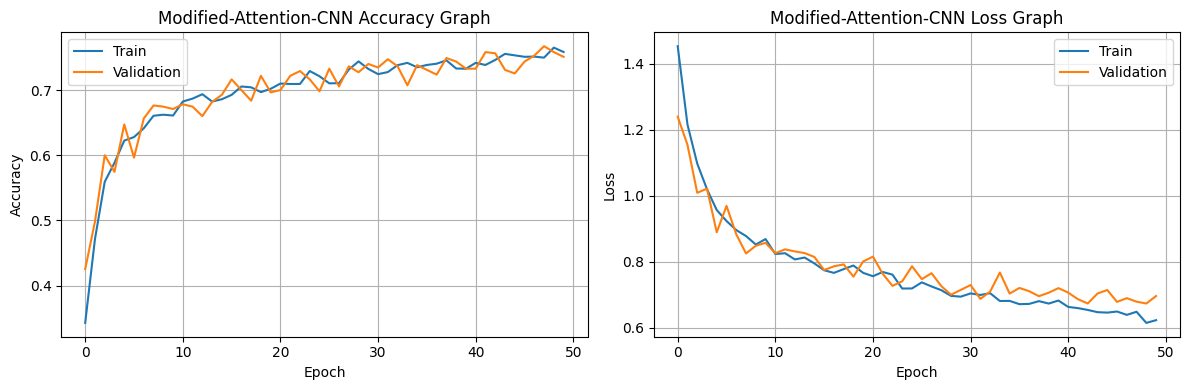

In [ ]:
model_builders = {
        "Modified-Attention-CNN": build_attention_cnn
}

results = []
all_results = []
EPOCHS = 50

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    model.summary()

    # Build the model by calling it with a dummy input
    dummy_input = tf.zeros((1, img_height, img_width, 3)) # Create a dummy input with the correct shape
    _ = model(dummy_input) # Call the model with the dummy input to build it

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확도 = {test_accuracy * 100:.2f}%')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()